# Comparing Lepton-Nucleus Collision Experiments

In [1]:
# For numerics
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# For TeX in plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# For colorblind-friendly plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())


#For setting ROOT path and accessing files
import sys
import os

ROOT = '/Volumes/T7/Research/Thesis/' #Change this to the path of the Thesis folder

if ROOT not in sys.path:
    sys.path.append(ROOT)
    
if os.getcwd() != ROOT:
    os.chdir(ROOT)

# For progress bar in loops
from tqdm import tqdm

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

from lepton_nucleus_collisions.experiments import E137, EIC, MuBeD, MuSIC, FinalState
from lepton_nucleus_collisions.compute import default_x, default_y

In [2]:
experiments = [E137, EIC, MuBeD, MuSIC]
experiment_TeX = [f'${{\\rm {experiment}}}$' for experiment in experiments]
TeX_dict = dict(zip(experiments, experiment_TeX))
experiment_colors = [colors[1], colors[0], colors[3], colors[2]]
color_dict = dict(zip(experiments, experiment_colors))

## Distribution Envelopes

Here, we define some functions which allow us to compute the envelopes of kinematic distributions between two masses. We also define some smooth functions which make the envelope less jagged.

In [3]:
def envelope(distributions):
    return np.nanmax(distributions, axis = 0)

def smooth(y, window = 10):
    y_new = np.ones(len(y) + window)
    y_new[window//2:-window//2] = y
    y_new[:window//2] = y[0]
    y_new[-window//2:] = y[-1]
    return np.convolve(y_new, np.ones(window)/window, mode = 'same')[window//2:-window//2]

# custom smooth function for the envelope...
def env_smooth(y, window = 10, clip = True):
    log_grad = np.gradient(np.log(y))
    log_grad = np.where(np.isfinite(log_grad), log_grad, 0)
    idcs = np.where(np.abs(np.diff(np.sign(log_grad))) == 2)[0]
    y_new = np.copy(y)
    if len(idcs) > 0:
        start = idcs[0]
        stop = idcs[-1] + 1
        kernel = np.ones(window)/window

        if len(y_new[start:stop]) < window:
            window = len(y_new[start:stop])
        y_new[start:stop] = smooth(y_new[start:stop], window = window)

    # if clip, then need to find regions where the difference between
    # neighboring points exceeds a certain tolerance (1% here)
    if clip:
        ratio = (np.roll(y, 1) + np.roll(y, -1))/(2*y)
        clip_region = np.where(np.abs(ratio - 1) > 0.01)[0]
        clip_region = clip_region[(clip_region > 0)*(clip_region < len(y)-1)]
        if len(clip_region) > 0:
        # clip region might have neighboring points. To deal with this, we 
        # find the indices which correspond to the start and stop of a 
        # "region" of neighboring points.
            split = np.where(np.diff(clip_region) != 1)[0] + 1
            blocks = np.split(clip_region, split)
            clip_start = np.concatenate([[block[0]-1]*len(block) for block in blocks])
            clip_stop = np.concatenate([[(block[-1]+1)%len(y)]*len(block) for block in blocks])
            y_new[clip_region] = (y[clip_start] + y[clip_stop])/2
    
    return y_new

Here is a helper function for plotting the distributions between the range x_min and x_max:

In [4]:
def plot_distributions(experiment, params,
                       x_min, x_max,
                       masses = None,
                       PV_angle = 0,
                       ax = None,
                       color = None,
                       frame = 'lab',
                       particle = 'boson',
                       n_pts = 1000,
                       scale = 'linear',
                       which = 'y',
                       var = 'eta',
                       smooth_dist = False,
                       dist_window = 20,
                       smooth_env = False,
                       env_window = 10,
                       clip = False):

    if not ax:
        ax = plt.gca()

    if not color:
        color = color_dict[experiment]
    
    if masses is None:
        masses = experiment.cached_masses(*params)

    final_states =[FinalState(*params, m, PV_angle) for m in masses]
                 
    if scale == 'linear':
        x = np.linspace(x_min, x_max, n_pts)
    else:
        x = np.geomspace(x_min, x_max, n_pts)

    if which == 'x':
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, x = x, x_var = var, frame = frame, particle = particle) for final_state in tqdm(final_states)]))
    else:
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, y = x, y_var = var, frame = frame, particle = particle) for final_state in tqdm(final_states)]))
    non_zero = np.where(dists.sum(axis = 1) != 0)[0]
    if len(non_zero) == 0:
        min_idx = 0
        max_idx = -1
    else:
        min_idx = non_zero[0]
        max_idx = non_zero[-1]

    if smooth_dist:
        dists = np.array([smooth(dist, window = dist_window) for dist in dists])
    
    env = envelope(dists)
    if smooth_env:
        env = env_smooth(env, window = env_window, clip = clip)
    ax.plot(x, dists[min_idx], color = color)
    ax.plot(x, dists[max_idx], color = color)
    ax.plot(x, env, color = color, linestyle = 'dotted', alpha = 0.5)
    ax.fill_between(x, env, color = color, alpha = 0.2)

    return masses[min_idx], masses[max_idx]

In [5]:
def compare_distributions(params,
                          ax1, ax2,
                          x1lim, x2lim,
                          y1lim = None,
                          y2lim = None,
                          mass1 = None,
                          mass2 = None,
                          n_pts_mass = 100,
                          PV_angle = 0,
                          frame = 'lab',
                          particle = 'boson',
                          n_pts = 1000,
                          scale = 'linear',
                          which = 'y',
                          var = 'eta',
                          var_TeX = '\\eta',
                          smooth_dist = False,
                          dist_window = 20,
                          smooth_env = False,
                          env_window = 10,
                          clip = False):

    if mass1 is None:
        mass1 = np.geomspace(1e-3, 5.0, n_pts_mass)

    if mass2 is None:
        mass2 = np.geomspace(1e-3, 40.0, n_pts_mass)

    # If params[2] is "li", this just means the process is diagonal
    diagonal = params[2] == 'li'
    
    axis_params = [[ax1,ax2], [mass1, mass2], [x1lim, x2lim], [y1lim, y2lim], ['e', 'mu'], [[E137, EIC], [MuBeD, MuSIC]]]

    for ax, mass, xlim, ylim, li, experiment_list in zip(*axis_params):

        if diagonal:
            params = (params[0], params[1], li, params[3])
        lf = params[2]
        li_TeX = li if li == 'e' else '\\' + li
        lf_TeX = lf if lf == 'e' else '\\' + lf

        # Plot distributions for each experiment
        for experiment in experiment_list:
            print(f'-----------------{experiment}-----------------')
            plot_distributions(experiment, params, *xlim,
                               masses = mass,
                               ax = ax,
                               PV_angle = PV_angle,
                               frame = frame,
                               particle = particle,
                               n_pts = n_pts,
                               scale = scale,
                               which = which,
                               var = var,
                               smooth_dist = smooth_dist,
                               dist_window = dist_window,
                               smooth_env = smooth_env,
                               env_window = env_window,
                               clip = clip)

            # Make legend
            ax.plot([100], color = color_dict[experiment], label = TeX_dict[experiment])
            ax.legend(fancybox = False,
                      facecolor = 'white',
                      edgecolor = 'black',
                      framealpha = 1,
                      loc = 'upper right',
                      fontsize = 8,
                      borderpad = 0.6)

        # Make grid 
        ax.grid()

        # x-axis
        ax.set_xlim(*xlim)
        ax.set_xscale(scale)

        # y-axis
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_yscale(scale)

        if particle == 'boson':
            particle_TeX = '\\varphi'
        else:
            particle_TeX = lf_TeX
    
        # Make title
        ax.set_title(f'${li_TeX}^- A_Z \\rightarrow {lf_TeX}^- A_Z \\varphi$', fontsize = 14)
        ax.set_xlabel(f'${var_TeX}_{{{particle_TeX}}}$', fontsize = 12)
        ax.set_ylabel(f'$\\rho_{{{var_TeX}}}({var_TeX}_{{{particle_TeX}}})$', fontsize = 12)        

### Pseudorapidity ($\eta$) distributions:

Now, we can plot the envelope of the pseudo-rapidity distributions for the diagonal production $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$.

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.31it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 34.52it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.36it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.78it/s]


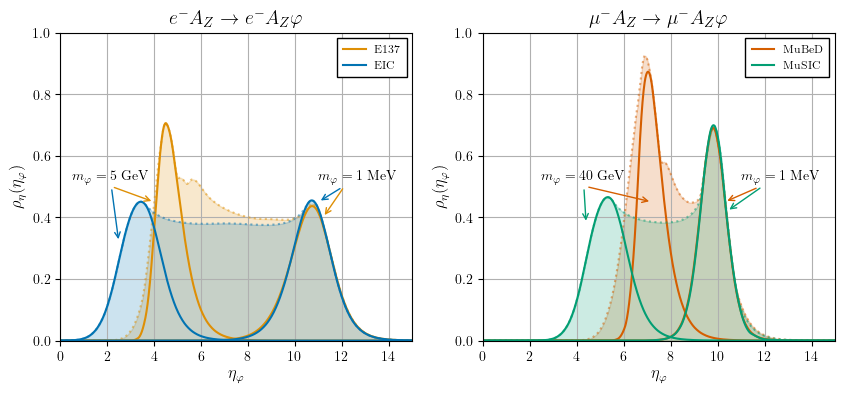

In [6]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'li', 'scalar'

kwargs = {'n_pts_mass': 500, # Choose 500 for the paper plot for increased precision
          'which': 'y',
          'scale': 'linear',
          'var': 'eta',
          'var_TeX': '\\eta',
          'frame': 'lab',
          'particle': 'boson',
          'smooth_dist': True,
          'smooth_env': True
         }

compare_distributions(params, ax1, ax2, (0, 15), (0, 15), **kwargs)


# Some annotations for the masses at either
# end of the distribution envelope.
ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (11, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (12.1, 0.5),
             xy = (11.2, 0.4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (0.5, 0.52),
             xy = (2.5, 0.32),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (2.2, 0.5),
             xy = (4, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))


ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (10.3, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))
ax2.annotate('',
             xytext = (11.9, 0.5),
             xy = (10.4, 0.42),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))


ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (2.5, 0.52),
             xy = (4.4, 0.38),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (4.4, 0.5),
             xy = (7.2, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)

plt.savefig(ROOT + 'figures/chapter4/eta_distributions_diagonal.pdf', format = 'pdf', bbox_inches = 'tight')

This doesn't appear in the thesis, but we can also plot the envelope of the distributions for the off-diagonal $\tau$ production:

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.46it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.29it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.97it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.55it/s]


(0.0, 1.0)

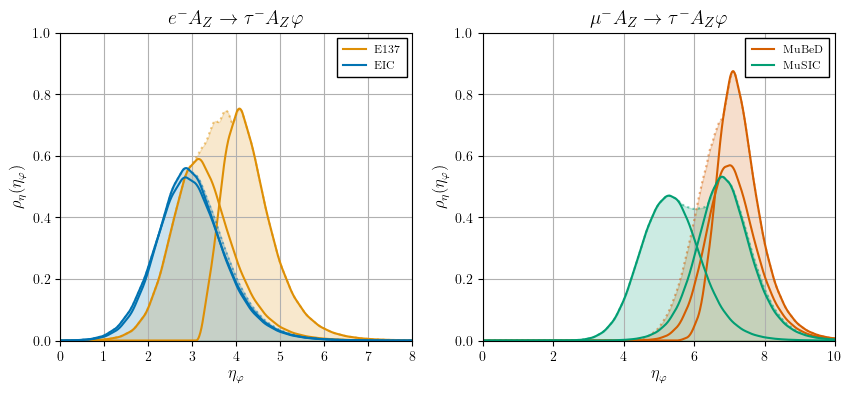

In [7]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'tau', 'scalar'

kwargs = {'which': 'y',
          'scale': 'linear',
          'var': 'eta',
          'var_TeX': '\\eta',
          'frame': 'lab',
          'particle': 'boson',
          'smooth_dist': True,
          'smooth_env': True
         }

compare_distributions(params, ax1, ax2, (0, 8), (0, 10), **kwargs)

ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)

And we can plot the distributions for the final-state lepton instead. Here is that for a particle with on-diagonal interactions:

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.59it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.71it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.64it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.60it/s]


(0.0, 0.8)

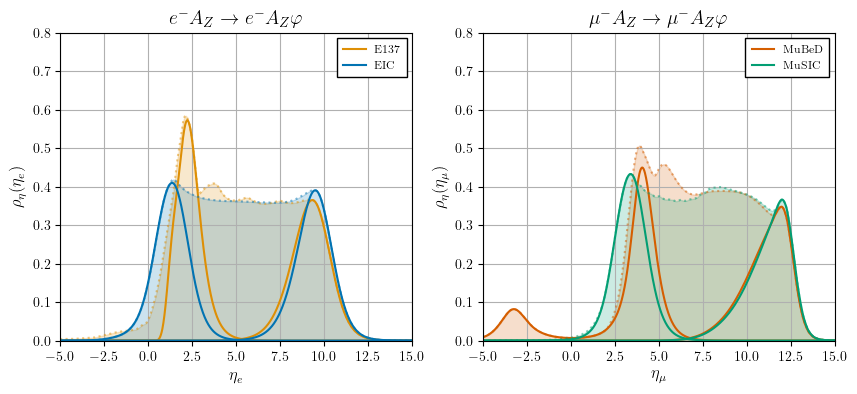

In [8]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'li', 'scalar'

kwargs = {'which': 'y',
          'scale': 'linear',
          'var': 'eta',
          'var_TeX': '\\eta',
          'frame': 'lab',
          'particle': 'lepton', #now lepton
          'smooth_dist': True,
          'smooth_env': True
         }

compare_distributions(params, ax1, ax2, (-5, 15), (-5, 15), **kwargs)

ax1.set_ylim(0, 0.8)
ax2.set_ylim(0, 0.8)

And the case of off-diagonal production of a $\tau$:

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.79it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.91it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.36it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.88it/s]


(0.0, 1.0)

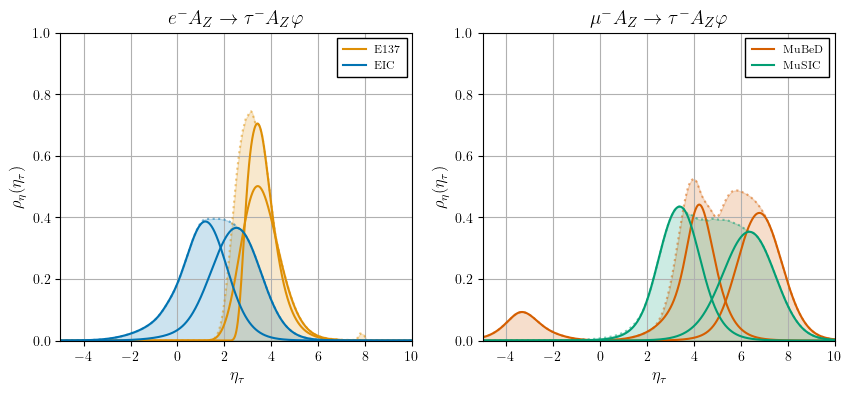

In [9]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'tau', 'scalar'

kwargs = {'which': 'y',
          'scale': 'linear',
          'var': 'eta',
          'var_TeX': '\\eta',
          'frame': 'lab',
          'particle': 'lepton', #now lepton
          'smooth_dist': True,
          'smooth_env': True
         }


compare_distributions(params, ax1, ax2, (-5, 10), (-5, 10), **kwargs)

ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)

We can also plot distributions w.r.t. a different variable. $\theta$, $\sin{\theta}$, $\sin({\theta}/2)$, and $\cos{\theta}$ are supported. Here is an example for the on-diagonal scenario again, plotting the angular distribution $\theta$. We do not show t

### Boost ($\gamma$) distributions:

We can do the same but for $\gamma$ here. First, the $\gamma_\varphi$ distribution for $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$.

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.57it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.62it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.79it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.08it/s]


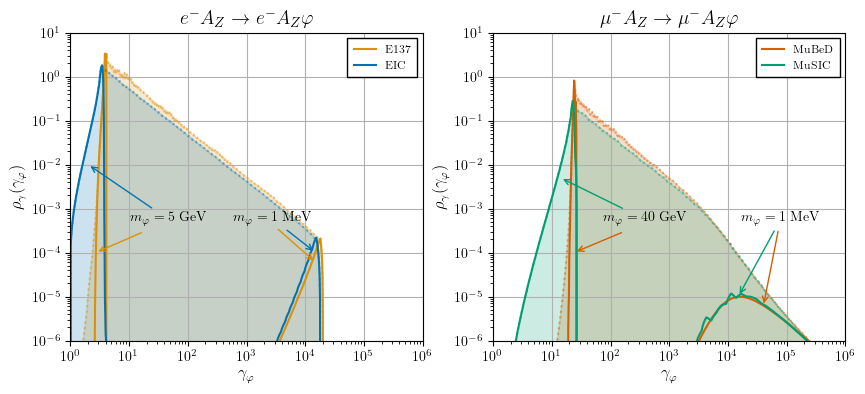

In [10]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'li', 'scalar'

kwargs = {'which': 'x',
          'scale': 'log',
          'var': 'gamma',
          'var_TeX': '\\gamma',
          'frame': 'lab',
          'particle': 'boson',
          'smooth_dist': False,
          'smooth_env': True,
          'env_window': 10
         }

compare_distributions(params, ax1, ax2, (1e0, 1e6), (1e0, 1e6), **kwargs)

# Some annotations for the masses at either
# end of the distribution envelope.
ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (600, 5e-4),
             xy = (1.5e4, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (3.2e3, 3.7e-4),
             xy = (1.5e4, 6e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (10.2, 5e-4),
             xy = (2, 1e-2),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (18, 3e-4),
             xy = (2.7, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (1.7e4, 5e-4),
             xy = (1.5e4, 1e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (7.3e4, 3.5e-4),
             xy = (4e4, 6e-6),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (73, 5e-4),
             xy = (14, 5e-3),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (170, 3e-4),
             xy = (24, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax1.set_ylim(1e-6, 1e1)
ax2.set_ylim(1e-6, 1e1)

plt.savefig(ROOT + 'figures/chapter4/gamma_distributions_diagonal.pdf', format = 'pdf', bbox_inches = 'tight')

Next, the $\gamma_\varphi$ distribution for $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$.

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.41it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.13it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.21it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.15it/s]


(1e-07, 10.0)

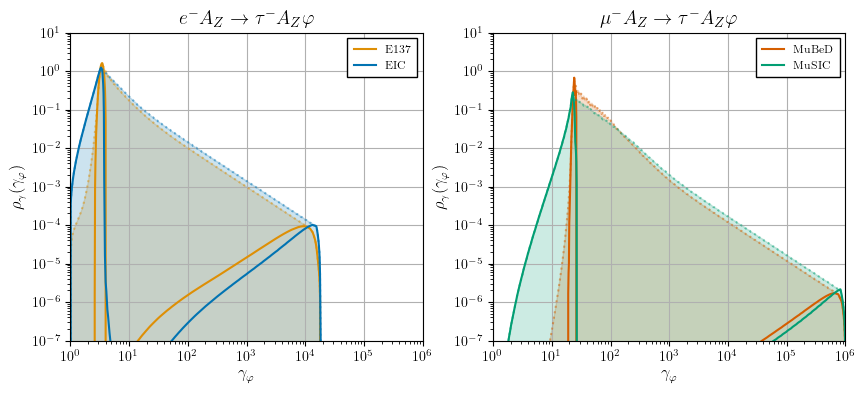

In [11]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'tau', 'scalar'

kwargs = {'which': 'x',
          'scale': 'log',
          'var': 'gamma',
          'var_TeX': '\\gamma',
          'frame': 'lab',
          'particle': 'boson',
          'smooth_dist': False,
          'smooth_env': True,
          'env_window': 10
         }

compare_distributions(params, ax1, ax2, (1e0, 1e6), (1e0, 1e6), **kwargs)

ax1.set_ylim(1e-7, 1e1)
ax2.set_ylim(1e-7, 1e1)

Next, the $\gamma_\ell$ distribution for $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$.

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.69it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.37it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.44it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.59it/s]


(1e-07, 10.0)

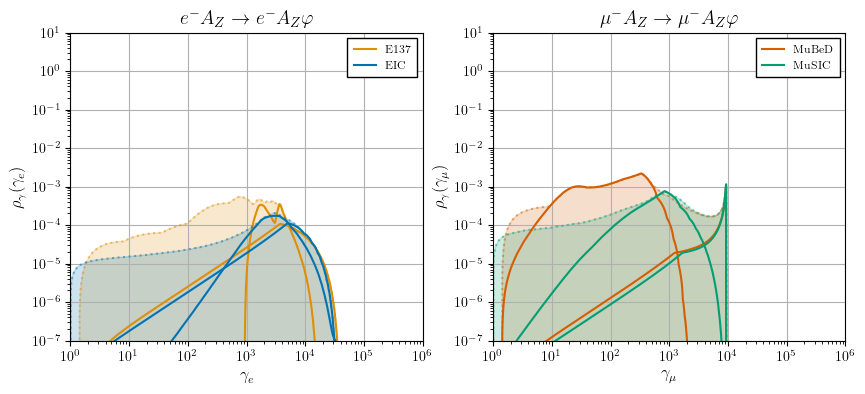

In [12]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'li', 'scalar'

kwargs = {'which': 'x',
          'scale': 'log',
          'var': 'gamma',
          'var_TeX': '\\gamma',
          'frame': 'lab',
          'particle': 'lepton', #now lepton
          'smooth_dist': False,
          'smooth_env': True,
          'env_window': 10,
         }

compare_distributions(params, ax1, ax2, (1e0, 1e6), (1e0, 1e6), **kwargs)

ax1.set_ylim(1e-7, 1e1)
ax2.set_ylim(1e-7, 1e1)

Finally, the $\gamma_\tau$ distribution for $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$.

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.23it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.07it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.94it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.10it/s]


(0.0001, 1.0)

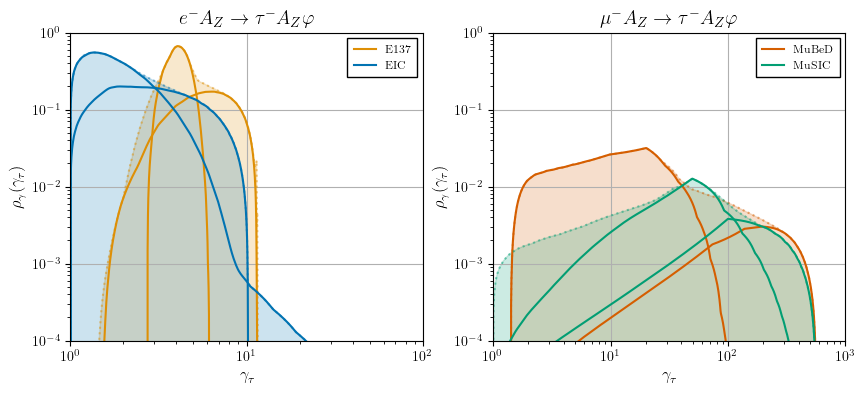

In [13]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'tau', 'scalar'

kwargs = {'which': 'x',
          'scale': 'log',
          'var': 'gamma',
          'var_TeX': '\\gamma',
          'frame': 'lab',
          'particle': 'lepton', #now lepton
          'smooth_dist': False,
          'smooth_env': True,
          'env_window': 10
         }

compare_distributions(params, ax1, ax2, (1e0, 1e2), (1e0, 1e3), **kwargs)

ax1.set_ylim(1e-4, 1e0)
ax2.set_ylim(1e-4, 1e0)

We can also plot the distributions of $x$ (energy fraction), $E$ (energy), $p$ (momentum), and $v$ (velocity). Here is the enelope of energy fraction distributions for $\varphi$ for the case $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$:

-----------------E137-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.42it/s]


-----------------EIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.38it/s]


-----------------MuBeD-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.85it/s]


-----------------MuSIC-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.96it/s]


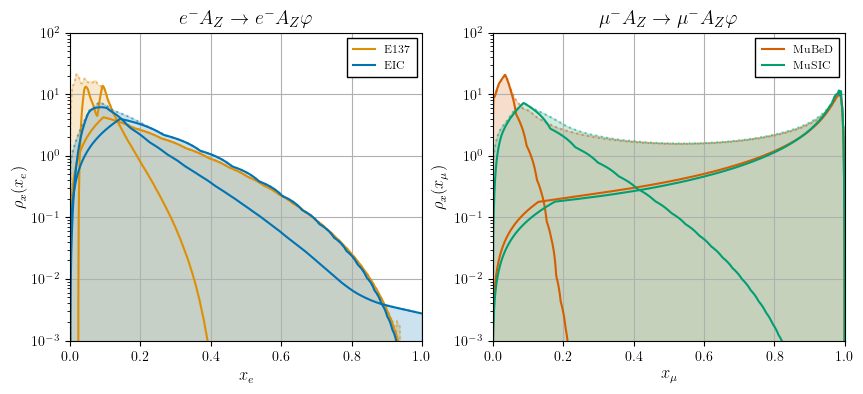

In [14]:
fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

params = 'exact', 1.0, 'li', 'scalar'

kwargs = {'which': 'x',
          'scale': 'linear',
          'var': 'x',
          'var_TeX': 'x',
          'frame': 'lab',
          'particle': 'lepton', #now lepton
          'smooth_dist': False,
          'smooth_env': True,
          'env_window': 10
         }

compare_distributions(params, ax1, ax2, (0, 1), (0, 1), **kwargs)

ax1.set_ylim(1e-3, 1e2)
ax1.set_yscale('log')
ax2.set_ylim(1e-3, 1e2)
ax2.set_yscale('log')

## Distribution Medians and Quartiles

We can also get a sense for the distributions by plotting the median and upper and lower quartile of each distribution. We opt to do this instead of the mean and standard deviation to avoid the standard deviation going beyond physical values (for example, $\bar{\gamma}-\sigma_\gamma$ may be less than $1$).

In [15]:
def plot_medians(experiment, params, masses = None, PV_angle = 0, ax = None, color = None, frame = 'lab', particle = 'boson', n_pts = 1000, which = 'y', var = 'eta'):

    if not ax:
        ax = plt.gca()

    if not color:
        color = color_dict[experiment]
    
    if masses is None:
        masses = experiment.cached_masses(*params)

    final_states =[FinalState(*params, m, PV_angle) for m in masses]

    if which == 'x':
        xs = np.array([default_x(experiment, final_state, frame = frame, particle = particle, n_pts = n_pts, x_var = var) for final_state in final_states])
    else:
        xs = np.array([default_y(n_pts = n_pts, y_var = var) for final_state in final_states])

    if which == 'x':
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, x = x, x_var = var, frame = frame, particle = particle) for x, final_state in zip(xs, tqdm(final_states))]))
    else:
        dists = np.nan_to_num(np.array([experiment.distribution(final_state, interpolate_mass = True, y = x, y_var = var, frame = frame, particle = particle) for x, final_state in zip(xs, tqdm(final_states))]))


    y_tots = np.trapezoid(dists, x = xs, axis = -1).reshape(-1, 1)
    
    y_ints = np.array([np.trapezoid(dists[:, :idx]/y_tots, x = xs[:, :idx], axis = -1) for idx in range(len(xs[0]))]).T

    x_50 = smooth(np.array([np.interp(0.5, y_ints[idx], xs[idx]) for idx in range(len(xs))]), window = 10)
    x_25 = smooth(np.array([np.interp(0.25, y_ints[idx], xs[idx]) for idx in range(len(xs))]), window = 10)
    x_75 = smooth(np.array([np.interp(0.75, y_ints[idx], xs[idx]) for idx in range(len(xs))]), window = 10)

    if np.any(np.isnan(x_50).sum() > 0):
        endpt = np.min(np.where(np.isnan(x_50))) - 1
    else:
        endpt = -1

    ax.fill_between(masses, x_25, x_75, color = color, alpha = 0.1)
    ax.plot(masses, x_25, color = color)
    ax.plot(masses, x_75, color = color)
    ax.plot(masses, x_50, color = color, linestyle = 'dotted', alpha = 0.5)
    
    #connect the edges
    xmin = x_25[endpt]
    xmax = x_75[endpt]
    ax.plot([masses[endpt], masses[endpt]], [xmin, xmax], color = color)

    ax.tick_params(which = 'both', direction = 'in')
    
    return ax    

In [16]:
def compare_median_plots(ax1, ax2,
                         xlim = None,
                         ylim = None,
                         xscale = 'log',
                         yscale = 'linear',
                         PV_angle = 0,
                         which = 'y',
                         var = 'eta',
                         var_TeX = '\\eta',
                         n_pts = 1000,
                         frame = 'lab',
                         particle = 'boson'):

    for idx, ax in enumerate([ax1, ax2]):
        if idx == 0:
            print('---------------l A_Z -> l A_Z \phi--------------')
        if idx == 1:
            print('---------------l A_Z -> \\tau A_Z \phi--------------')
        
        lf_TeX = '\\ell' if idx == 0 else '\\tau'
        particle_TeX = '\\varphi' if particle == 'boson' else lf_TeX
        for experiment in experiments:

            print(f'---------------{experiment}--------------')
            
            lf = experiment.lepton if idx == 0 else 'tau'
            params = 'exact', 1.0, lf, 'scalar'            
            masses = experiment.cached_masses(*params, PV_angle)[:-1]
            masses = np.geomspace(masses.min(), masses.max(), 500)
            plot_medians(experiment, params,
                         ax = ax,
                         masses = masses,
                         which = which,
                         var = var,
                         n_pts = 100,
                         frame = frame,
                         particle = particle)
            ax.plot([1e16], color = color_dict[experiment], label = TeX_dict[experiment])

        # Only plot the legend on the left plot
        if idx == 0:
            ax.legend(fancybox = False,
                      facecolor = 'white',
                      edgecolor = 'black',
                      framealpha = 1,
                      loc = 'lower left',
                      fontsize = 8,
                      borderpad = 0.6)

        # Format axis
        ax.grid()
        ax.tick_params(which = 'both', direction = 'in')

        # x-axis
        if xlim:
            ax.set_xlim(*xlim)
        if xscale:
            ax.set_xscale(xscale)
        ax.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

        # y-axis
        if ylim:
            ax.set_ylim(*ylim)
        if xscale:
            ax.set_yscale(yscale)
        ax.set_ylabel(f'${var_TeX}_{particle_TeX}$', fontsize = 12)

    # Title
    ax.set_title(f'$\\ell^- A_Z \\rightarrow {lf_TeX}^- A_Z \\varphi$', fontsize = 14)

### Pseudorapidity ($\eta$) Distributions 

To begin, let us plot the $\eta$ distributions for the $\varphi$ for $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$ and $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$.

---------------l A_Z -> l A_Z \phi--------------
---------------E137--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 161.97it/s]


---------------EIC--------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:05<00:00, 93.32it/s]


---------------MuBeD--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 165.04it/s]


---------------MuSIC--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 141.60it/s]


---------------l A_Z -> \tau A_Z \phi--------------
---------------E137--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 159.30it/s]


---------------EIC--------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:05<00:00, 92.94it/s]


---------------MuBeD--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 165.87it/s]


---------------MuSIC--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 140.03it/s]


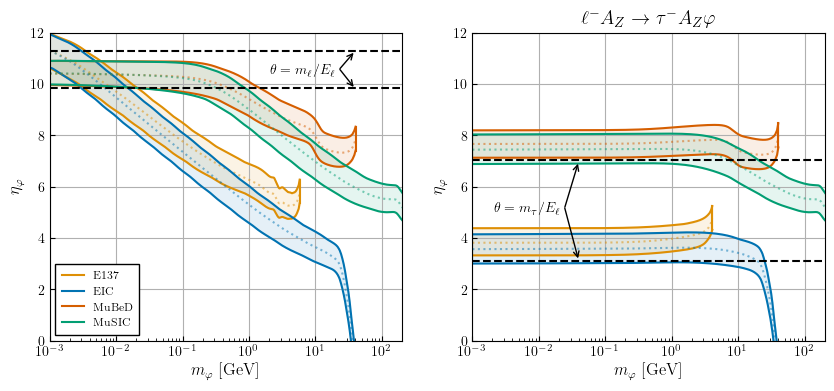

In [17]:
kwargs = {'yscale': 'linear',
          'which': 'y',
          'var': 'eta',
          'var_TeX': '\\eta',
          'frame': 'lab', 
         'particle': 'boson'
         }

fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

compare_median_plots(ax1, ax2, xlim = (1e-3, 2e2), ylim = (0, 12), **kwargs)

# Plot annotations
ax1.text(2.1, 10.4, '$\\theta = m_\\ell / E_\\ell$', color = 'black')
ax1.annotate('', (40, 9.8), (22, 10.65),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (40, 11.3), (22, 10.52),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax1.axhline(-np.log(np.tan(5.11e-4/(2*20))), color = 'black', linestyle = 'dashed')
ax1.axhline(-np.log(np.tan(0.106/(2*1000))), color = 'black', linestyle = 'dashed')

ax2.text(2.1e-3, 5, '$\\theta = m_\\tau / E_\\ell$', color = 'black')
ax2.annotate('', (4e-2, 3.1), (2.4e-2, 5.27),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (4e-2, 7), (2.4e-2, 5.10),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax2.axhline(-np.log(np.tan(1.77/(2*20))), color = 'black', linestyle = 'dashed')
ax2.axhline(-np.log(np.tan(1.77/(2*1000))), color = 'black', linestyle = 'dashed')

# Save figure
plt.savefig(ROOT + 'figures/chapter4/median_eta.pdf', format = 'pdf', bbox_inches = 'tight')

We can also plot the $\eta$ distributions for the $\ell^-$ for $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$ and the $\tau^-$ for $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$.

---------------l A_Z -> l A_Z \phi--------------
---------------E137--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 143.07it/s]


---------------EIC--------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:05<00:00, 96.02it/s]


---------------MuBeD--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 149.95it/s]


---------------MuSIC--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 144.96it/s]


---------------l A_Z -> \tau A_Z \phi--------------
---------------E137--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 139.03it/s]


---------------EIC--------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:05<00:00, 94.59it/s]


---------------MuBeD--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 138.42it/s]


---------------MuSIC--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 138.76it/s]


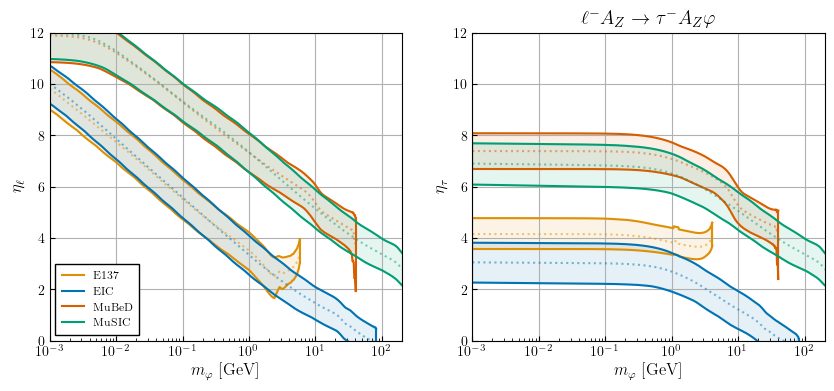

In [18]:
kwargs = {'yscale': 'linear',
          'which': 'y',
          'var': 'eta',
          'var_TeX': '\\eta',
          'frame': 'lab', 
         'particle': 'lepton' #now lepton
         }

fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

compare_median_plots(ax1, ax2, xlim = (1e-3, 2e2), ylim = (0, 12), **kwargs)


# Save figure
plt.savefig(ROOT + 'figures/chapter4/median_eta_lepton.pdf', format = 'pdf', bbox_inches = 'tight')

### Boost ($\gamma$) Distributions 

Now, we can plot the $\gamma$ distributions for the $\varphi$ for the $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$ and $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$.

In [ ]:
kwargs = {'yscale': 'log',
          'which': 'x',
          'var': 'gamma',
          'var_TeX': '\\gamma',
          'frame': 'lab', 
         'particle': 'boson'
         }

fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

compare_median_plots(ax1, ax2, xlim = (1e-3, 2e2), ylim = (1e0, 1e6), **kwargs)

# Plot annotations
ax1.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

x = np.geomspace(1e-3, 200, 1000)

ax1.plot(x, 20/x, color = 'black', linestyle = 'dashed')
ax1.plot(x, 1000/x, color = 'black', linestyle = 'dashed')

ax2.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax2.plot(x, 20/x, color = 'black', linestyle = 'dashed')
ax2.plot(x, 1000/x, color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\gamma_\\tau$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)


# Save figure
plt.savefig(ROOT + 'figures/chapter4/median_gamma.pdf', format = 'pdf', bbox_inches = 'tight')

---------------l A_Z -> l A_Z \phi--------------
---------------E137--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 141.58it/s]


---------------EIC--------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:05<00:00, 84.61it/s]


---------------MuBeD--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 143.93it/s]


---------------MuSIC--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:04<00:00, 116.89it/s]


---------------l A_Z -> \tau A_Z \phi--------------
---------------E137--------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:03<00:00, 129.51it/s]


---------------EIC--------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [00:06<00:00, 72.72it/s]


---------------MuBeD--------------


 61%|████████████████████████████████████████████████████████████▏                                      | 304/500 [00:01<00:01, 151.67it/s]

And finally, we can plot the $\gamma$ distributions for the $\ell^-$ for the $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$ and the $\tau^-$ for $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$.

In [ ]:
kwargs = {'yscale': 'log',
          'which': 'x',
          'var': 'gamma',
          'var_TeX': '\\gamma',
          'frame': 'lab', 
         'particle': 'lepton' #now lepton
         }

fig = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

compare_median_plots(ax1, ax2, xlim = (1e-3, 2e2), ylim = (1e0, 1e4), **kwargs)

# Save figure
plt.savefig(ROOT + 'figures/chapter4/median_gamma_lepton.pdf', format = 'pdf', bbox_inches = 'tight')